# Data Scientist Professional Practical Exam Submission


# Introduction

## About Tasty Bytes
Tasty Bytes was founded in 2020 in the midst of the Covid Pandemic. The world wanted
inspiration so we decided to provide it. We started life as a search engine for recipes, helping
people to find ways to use up the limited supplies they had at home.
Now, over two years on, we are a fully fledged business. For a monthly subscription we will put
together a full meal plan to ensure you and your family are getting a healthy, balanced diet
whatever your budget. Subscribe to our premium plan and we will also deliver the ingredients
to your door.

## Customer Request

Hi,
We haven’t met before but I am responsible for choosing which recipes to display on the
homepage each day. I have heard about what the data science team is capable of and I
was wondering if you can help me choose which recipes we should display on the home
page?

At the moment, I choose my favorite recipe from a selection and display that on the home
page. We have noticed that traffic to the rest of the website goes up by as much as 40% if I
pick a popular recipe. But I don’t know how to decide if a recipe will be popular. More traffic
means more subscriptions so this is really important to the company.

Can your team:
- Predict which recipes will lead to high traffic?
- Correctly predict high traffic recipes 80% of the time?

We need to make a decision on this soon, so I need you to present your results to me by the
end of the month. Whatever your results, what do you recommend we do next?
Look forward to seeing your presentation.

![Screenshot 2024-03-11 202305](Screenshot%202024-03-11%20202305.png)


## Results

The prediction of the expected traffic has been successful with the highest accuracy score of 81%, exceeding the customer request by 1%.

The optimum model for the prediction is Logistic Regression having tried multiple different models such as;

- Random Forest Classifier
- XGBoost Classifier
- Linear Discriminant Analysis

Following fine tuning, the best model was a Logistic Regression model

**Fine Tuned Logistic Regression**

              precision    recall  f1-score   support

           0       0.74      0.70      0.72        69
           1       0.84      0.87      0.85       129

    accuracy                           0.81       198

This model shows good precision, recall and therefore f1 score on the target class, meaning, that if a recipe is truly a high traffic item, this model is likely to be accurate.

This in combination with the overall accuracy of 81% indicates that this model will be satisfactory to the customer.

# Data Validation

In [1]:
# Loading all the packages required

# Data Review and Preprocessing
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from pycaret.classification import *
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier

## Loading data and initial exploration

In [2]:
df = pd.read_csv('recipe_site_traffic_2212.csv')
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


Lets first summarise wich columns have null data

In [3]:
df.isna().sum()

recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64

It appears that there are 52 rows that are missing the relevant data of calories, carbohydrate, sugar and protien. In addition to this, the target variable has 373 null values but this is likely due to the categorisation by the company. 

From this point on I am assuming that the null values are in fact the low traffic results.

## Distribution of numerical data

The following outputs the distribution of data for the numerical columns in the data (with the null rows removed). 

This shows that the majority of data is skewed to the left of the plot and therefore for imputing values, the median may be a better choice as to not be biased by a few high content/calorie values.

Number of serving has also been visualised here although not for the purpose of imputing as there are no missing entries. However, we can see from the data that there are a couple of additional quantities that dont meet the expectation.

The "as a snack" serving types will be removed and replaced with the integer before this statement. 

For example "4 as a snack" will be converted to 4

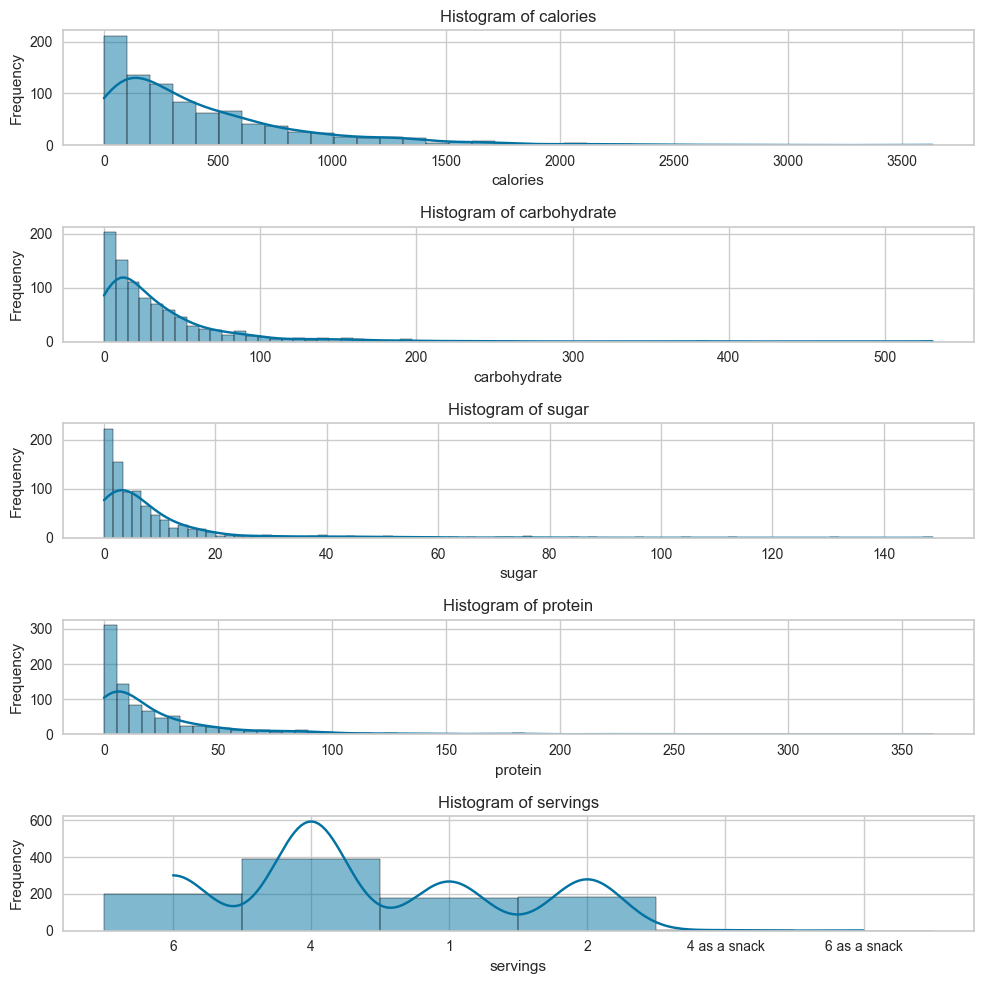

In [4]:
dist_columns = ['calories', 'carbohydrate', 'sugar', 'protein', 'servings']
fig, axs = plt.subplots(len(dist_columns), 1, figsize=(10, 10))

for i, col in enumerate(dist_columns):
    sns.histplot(data=df.dropna(subset=[col]), x=col, ax=axs[i], kde=True)  # Plotting on the ith subplot
    axs[i].set_title(f'Histogram of {col}')  # Optional: Adding a title to each subplot
    axs[i].set_ylabel('Frequency')  # Optional: Setting Y-axis label

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

## Null Data

The target variable will be filled with 'Low' and then the null values within the table will be summarised

In [5]:
df['high_traffic'] = df['high_traffic'].fillna('Low')
df

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,Low
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,Low
...,...,...,...,...,...,...,...,...
942,943,1161.00,5.31,22.39,44.22,Lunch/Snacks,2,Low
943,944,NaN,NaN,NaN,NaN,Potato,2,High
944,945,951.74,29.42,3.57,13.87,Pork,2,High
945,946,266.61,35.77,0.97,8.07,Potato,6,High


In [6]:
df['category'] =  df['category'].str.replace(' Breast', '')

In [7]:
df[df['calories'].isnull()]

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
23,24,NaN,NaN,NaN,NaN,Meat,2,Low
48,49,NaN,NaN,NaN,NaN,Chicken,4,Low
82,83,NaN,NaN,NaN,NaN,Meat,4,High
89,90,NaN,NaN,NaN,NaN,Pork,6,High
116,117,NaN,NaN,NaN,NaN,Chicken,6,High
121,122,NaN,NaN,NaN,NaN,Dessert,2,High
136,137,NaN,NaN,NaN,NaN,One Dish Meal,2,High
149,150,NaN,NaN,NaN,NaN,Potato,2,High
187,188,NaN,NaN,NaN,NaN,Pork,4,High


The data above indicates that the 52 missing values are all due to the same rows for each feature and therefore not spread accross the whole dataset.

These could be removed if required. However, I will try to impute data into these rows based upon the median of each category

In [8]:
df_grouped = df.groupby('category').agg(np.median)
df_grouped.reset_index(inplace=True)
df_grouped

,category,recipe,calories,carbohydrate,sugar,protein
0,Beverages,490.5,126.455,11.250,8.075,0.410
1,Breakfast,398.5,229.380,28.420,4.830,11.685
2,Chicken,480.0,379.160,15.490,3.500,33.170
3,Dessert,441.0,288.550,38.550,24.650,4.810
4,Lunch/Snacks,478.0,369.505,31.985,2.750,12.965
5,Meat,429.0,460.870,19.115,3.385,28.530
6,One Dish Meal,522.0,419.280,25.430,4.040,28.480
7,Pork,577.5,399.260,19.560,5.230,29.820
8,Potato,547.0,269.460,32.540,2.640,5.900
9,Vegetable,465.0,124.305,13.335,3.700,4.835


## Impute missing values

I will impute the median of each food category type into the missing values. The data is not evenly distibuted and skewed to the left. There is an assumption that food categories will be more comparable in terms of their macronutrients.

For example, 

Beverages are unlikely to have a high protein content whan compared to pork or chicken.

I believe that this method will be more accurate than other imputation techniques.

In [9]:
# Create a dictionary for each nutrient mean by category for easier lookup
mean_values_dict = df_grouped.set_index('category')[['calories', 'carbohydrate', 'sugar', 'protein']].to_dict('index')

# Function to fill NaN values with the category mean
def fill_with_category_mean(row, nutrient):
    if pd.isnull(row[nutrient]):
        return mean_values_dict[row['category']][nutrient]
    else:
        return row[nutrient]

# Fill NaN values for each nutrient based on its category mean
for nutrient in ['calories', 'carbohydrate', 'sugar', 'protein']:
    df[nutrient] = df.apply(fill_with_category_mean, nutrient=nutrient, axis=1)

# Display the dataframe to verify the changes
df

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,399.26,19.56,5.23,29.82,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,Low
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,Low
...,...,...,...,...,...,...,...,...
942,943,1161.00,5.31,22.39,44.22,Lunch/Snacks,2,Low
943,944,269.46,32.54,2.64,5.90,Potato,2,High
944,945,951.74,29.42,3.57,13.87,Pork,2,High
945,946,266.61,35.77,0.97,8.07,Potato,6,High


## Correct the serving size values



The food serving sizes are incorrect due to the snack addition to the serving. For the purpose of this analysis, the additional string related to the serving size will be removed.

The corrected distributions of the data will be reviewed.

In [10]:
df['servings'] =  df['servings'].str.replace(' as a snack', '')

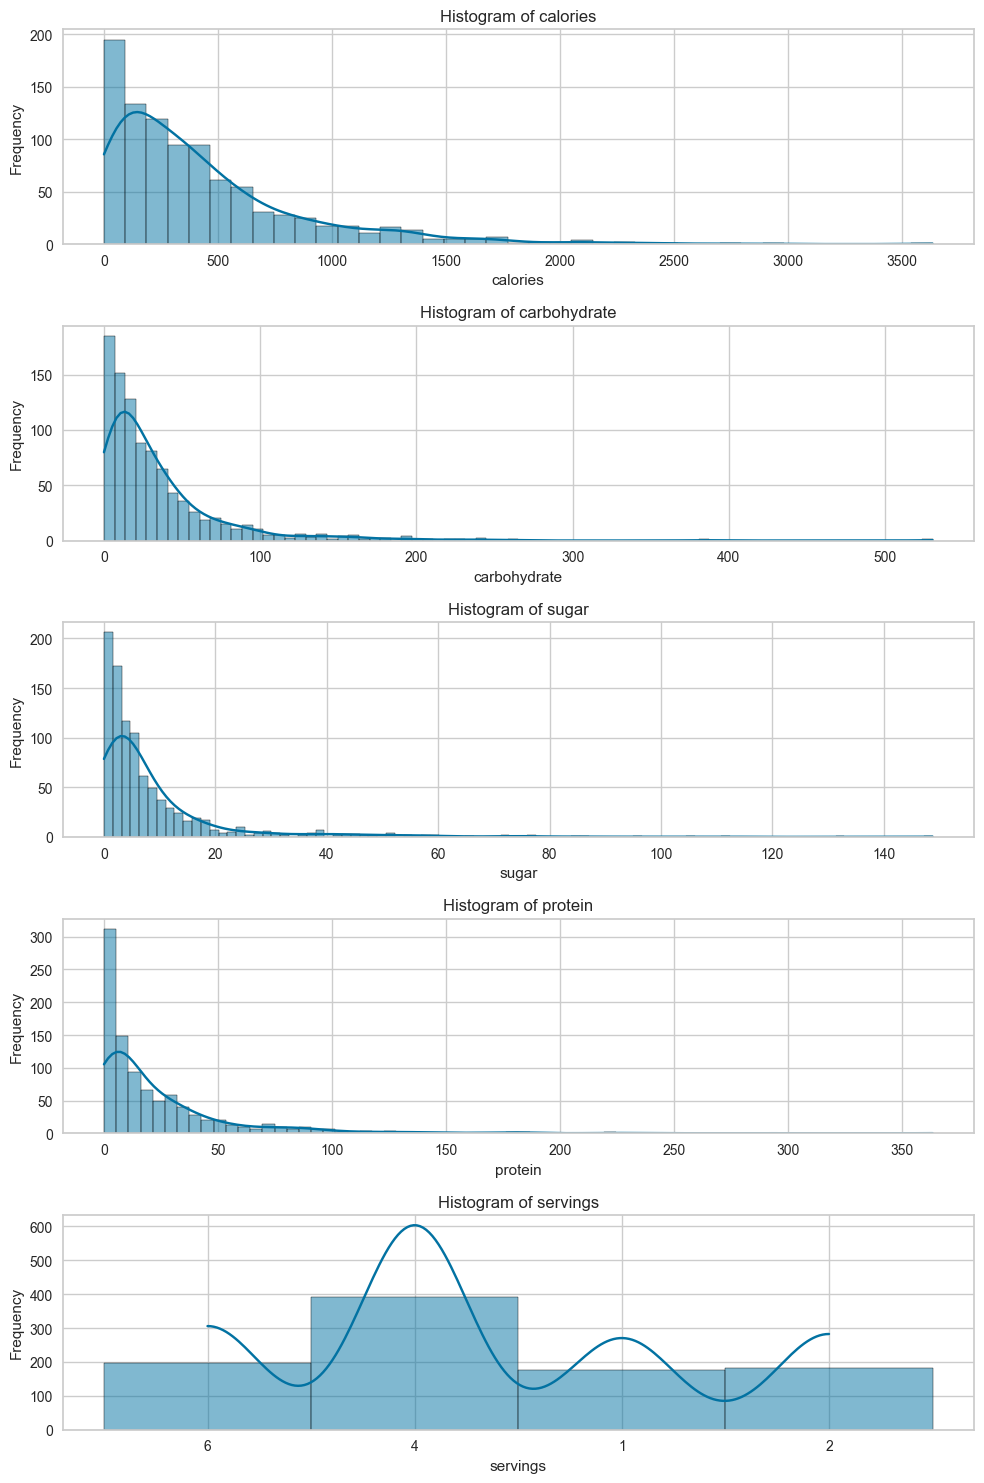

In [11]:
dist_columns = ['calories', 'carbohydrate', 'sugar', 'protein', 'servings']
fig, axs = plt.subplots(len(dist_columns), 1, figsize=(10, 15))

for i, col in enumerate(dist_columns):
    sns.histplot(data=df, x=col, ax=axs[i], kde=True)  # Plotting on the ith subplot
    axs[i].set_title(f'Histogram of {col}')  # Optional: Adding a title to each subplot
    axs[i].set_ylabel('Frequency')  # Optional: Setting Y-axis label

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

## Review of Outliers

To further interogate the distribution of the data, I've used box plots as this will show any potential outliers. Generally, we can visualise the mean, interqurtile range and the upper and lower limits.

Values outside of the upper and lower limits may be outliers. However, when it comes to food, there are usually going to be some high calorie meals so stripping the data too much would be unwise.

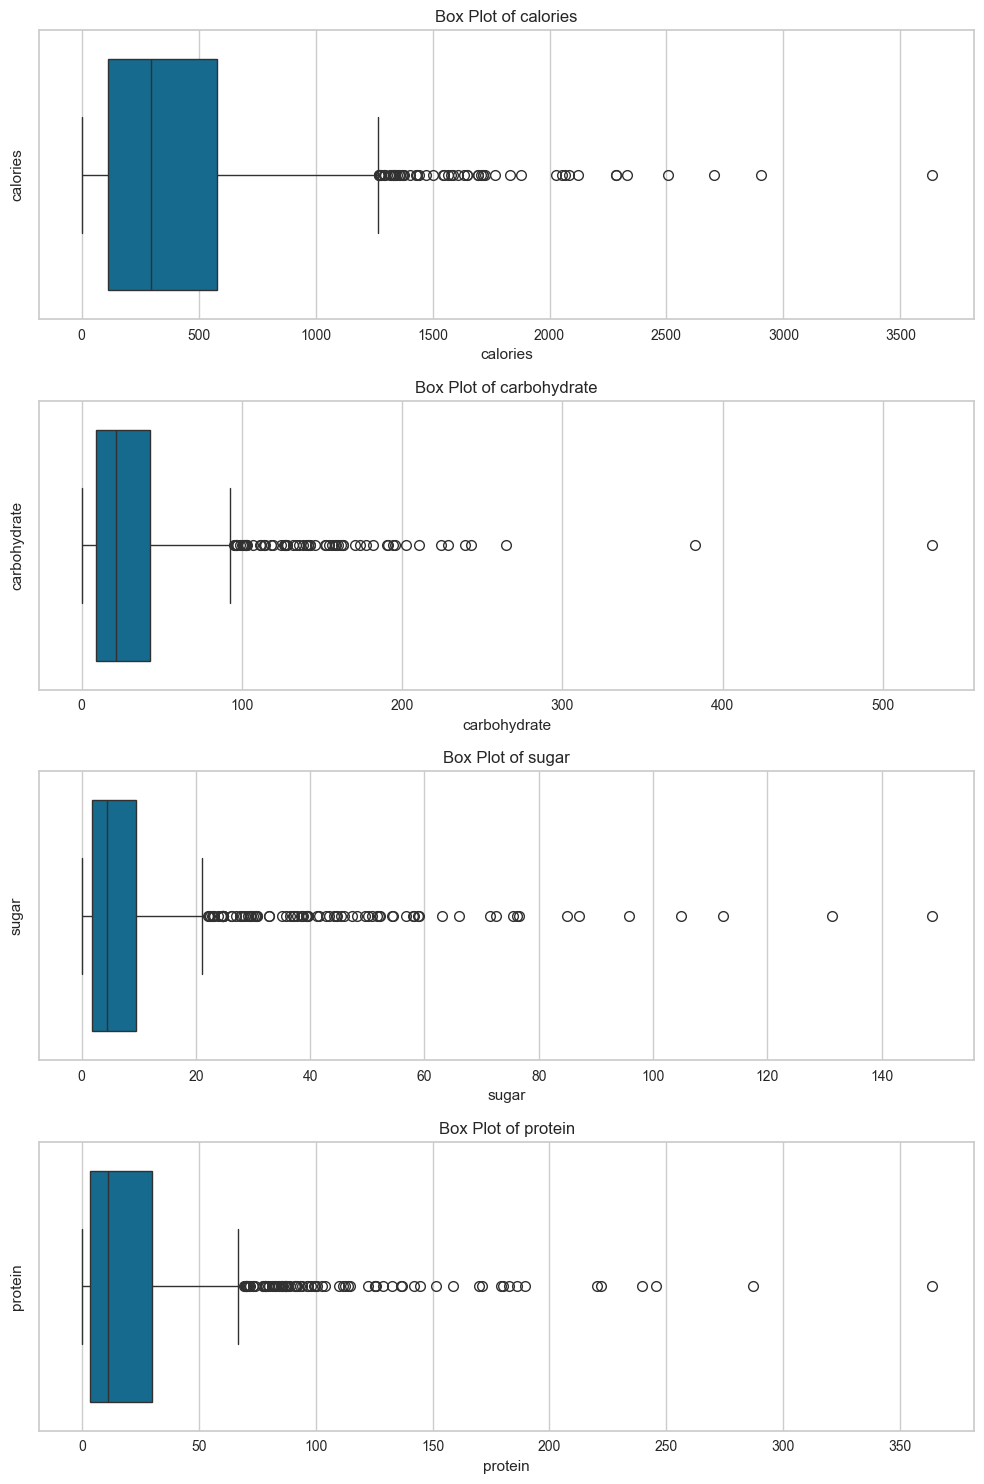

In [12]:
dist_columns = ['calories', 'carbohydrate', 'sugar', 'protein']
fig, axs = plt.subplots(len(dist_columns), 1, figsize=(10, 15))

for i, col in enumerate(dist_columns):
    sns.boxplot(data=df, x=col, ax=axs[i])  # Plotting on the ith subplot
    axs[i].set_title(f'Box Plot of {col}')  # Optional: Adding a title to each subplot
    axs[i].set_ylabel(f'{col}')  # Optional: Setting Y-axis label

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

The are some really high values for all of the features containing continuous data. To ensure that the dataset will not be trimmed too much, the z score will be used. I've gone for a z score criteria of 2 based on some tweaking od the data.

In [13]:
# Fill null values with the median for specified columns
columns_to_fill = ['carbohydrate', 'sugar', 'protein']

# Calculate Z-scores for the specified columns
z_scores = df[columns_to_fill].apply(zscore)

# Define outliers as rows where the absolute Z-score is greater than 2.25 in any of the specified columns
outliers = (z_scores.abs() > 1).any(axis=1)

# Data without outliers
data_without_outliers = df[~outliers]

original_shape = df.shape
cleaned_shape = data_without_outliers.shape

(original_shape, cleaned_shape)

((947, 8), (693, 8))

In [14]:
# Fill null values with the median for specified columns
columns_to_fill = ['calories']

# Calculate Z-scores for the specified columns
z_scores = df[columns_to_fill].apply(zscore)

# Define outliers as rows where the absolute Z-score is greater than 2.25 in any of the specified columns
outliers = (z_scores.abs() > 2).any(axis=1)

# Data without outliers
data_without_outliers = data_without_outliers[~outliers]

In [15]:
data_without_outliers

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,399.26,19.56,5.23,29.82,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,Low
4,5,27.05,1.85,0.80,0.53,Beverages,4,Low
5,6,691.15,3.46,1.65,53.93,One Dish Meal,2,High
...,...,...,...,...,...,...,...,...
942,943,1161.00,5.31,22.39,44.22,Lunch/Snacks,2,Low
943,944,269.46,32.54,2.64,5.90,Potato,2,High
944,945,951.74,29.42,3.57,13.87,Pork,2,High
945,946,266.61,35.77,0.97,8.07,Potato,6,High


Now that the data has been trimmed, the data looks a lot better with only a few outliers that I have chosen to keep so that the dataset doesnt get too small. In addition, I could make an assumption that high calorie meals may be popular, as some of the most popular chains in the world sell high calorie foods.

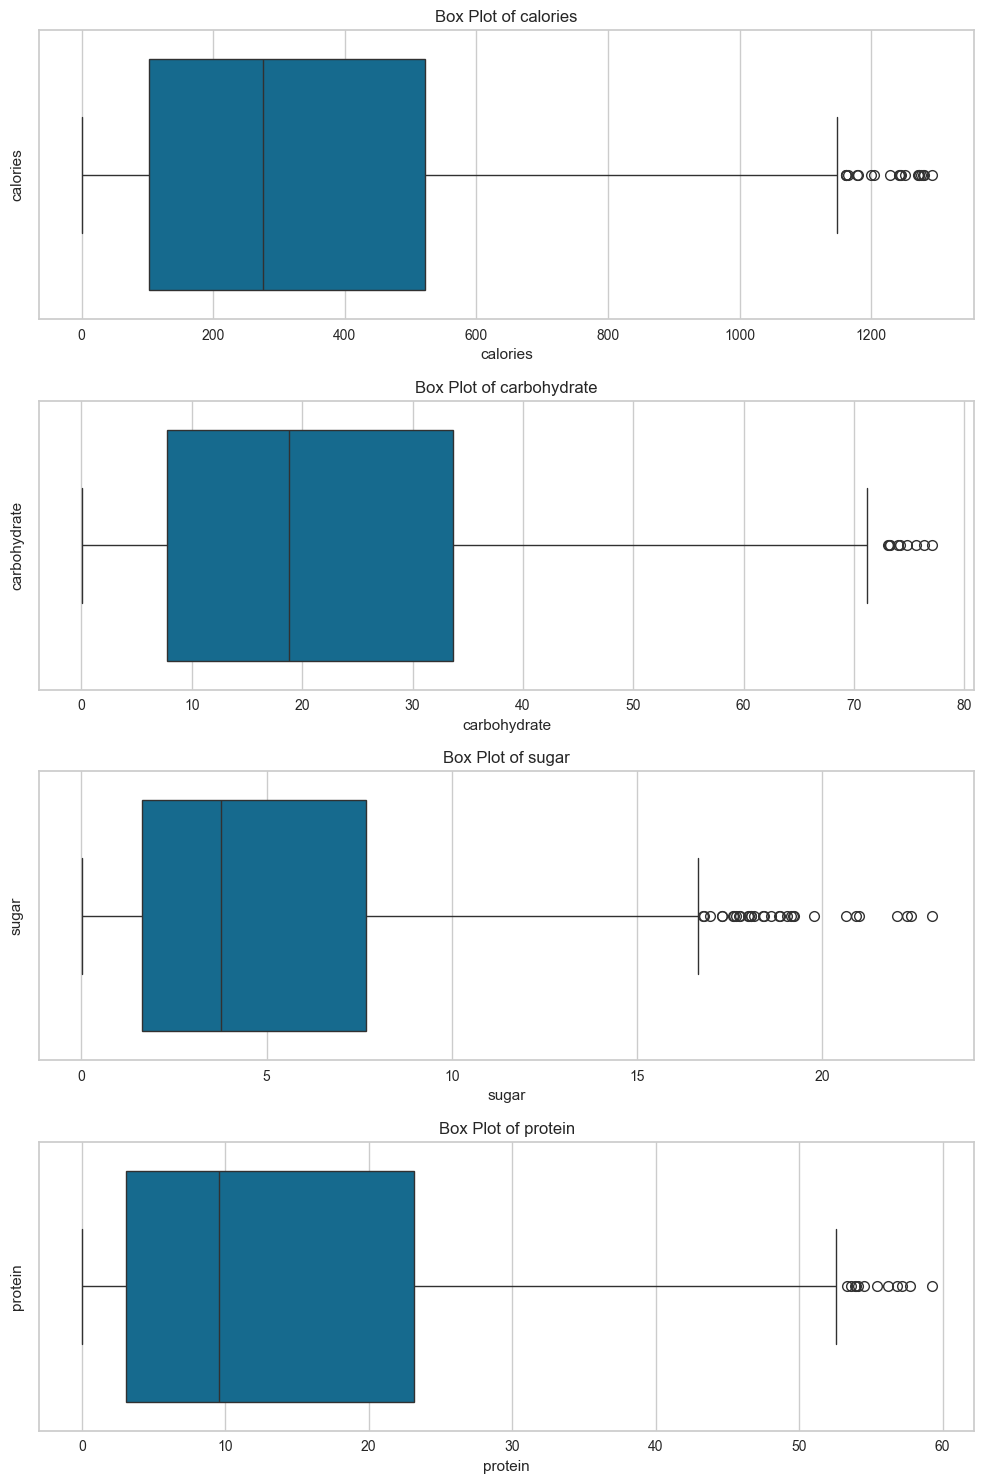

In [16]:
dist_columns = ['calories', 'carbohydrate', 'sugar', 'protein']
fig, axs = plt.subplots(len(dist_columns), 1, figsize=(10, 15))

for i, col in enumerate(dist_columns):
    sns.boxplot(data=data_without_outliers, x=col, ax=axs[i])  # Plotting on the ith subplot
    axs[i].set_title(f'Box Plot of {col}')  # Optional: Adding a title to each subplot
    axs[i].set_ylabel(f'{col}')  # Optional: Setting Y-axis label

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

Lets doublecheck the dtypes to make sure they are as expected

In [17]:
data_without_outliers.dtypes

recipe            int64
calories        float64
carbohydrate    float64
sugar           float64
protein         float64
category         object
servings         object
high_traffic     object
dtype: object

This meets the expectations of the data types. To summarise;

1. **recipe           - int64**  - This is the recipe id and will be removed for further analysis
2. **calories        - float64**  - Calories is a continuous number as expected
3. **carbohydrate   - float64**  - Carbohydrate is a continuous number as expected
4. **sugar          - float64**  - Sugar is a continuous number as expected
5. **protein        - float64**  - Protein is a continuous number as expected 
6. **category       -  object**  - The category as the name suggests is categorical data and therefore stored as an object. Will likely need                            to be converted to a numerical data type such as one hot encoding for analysis.
7. **servings        -  object**  - Serving is value between 1 and 6 (discrete data) and therefore object is applicable as it isn't ordinal
8. **high_traffic   -  object**  - The labelled data is categorical. This will be encoded for analysis to High = 1 and Low = 0


# Visualising the Data

## Visualising the Features

The first step in visualising the data is to have a look at the correlations between the continuous variables 

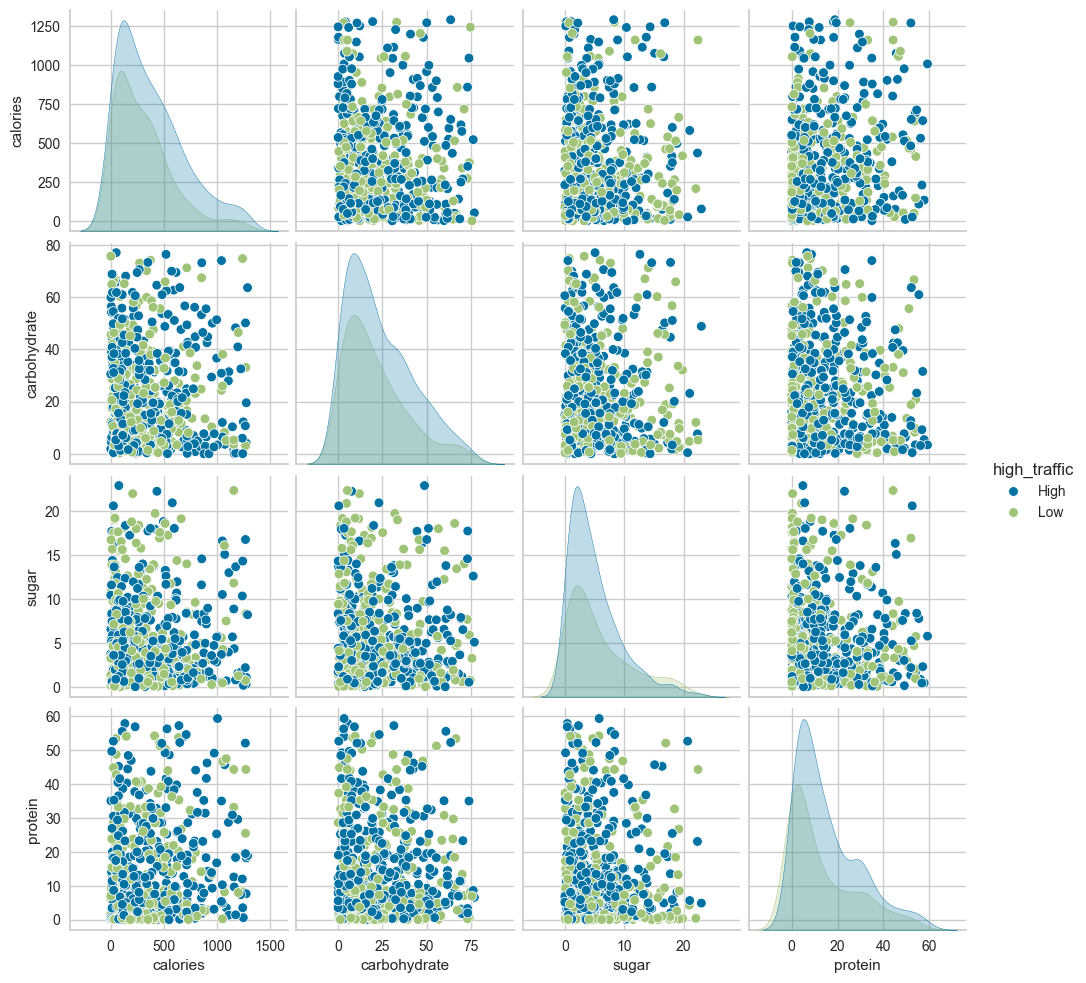

In [18]:
sns.pairplot(data=data_without_outliers.drop(['recipe', 'category'], axis=1), hue='high_traffic')

<AxesSubplot: >

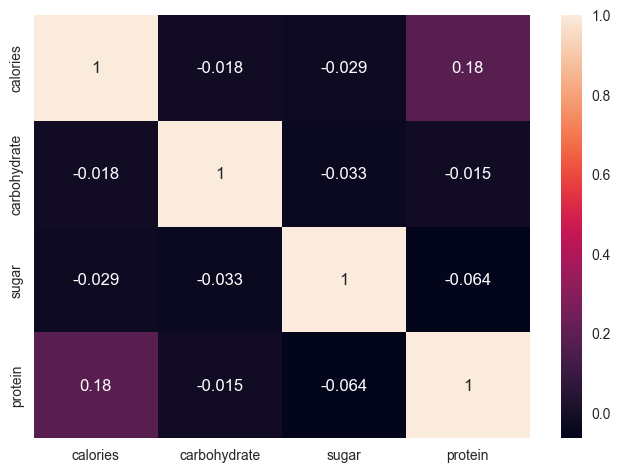

In [19]:
corr_df = data_without_outliers.drop(['recipe', 'category', 'high_traffic'], axis=1).corr()
sns.heatmap(corr_df, annot=True)

There is no colinearity observed in the data.

There is a very small correlation between calories and protien but this is expected as foods typically high in protien such as meat will also have higher calorific content.

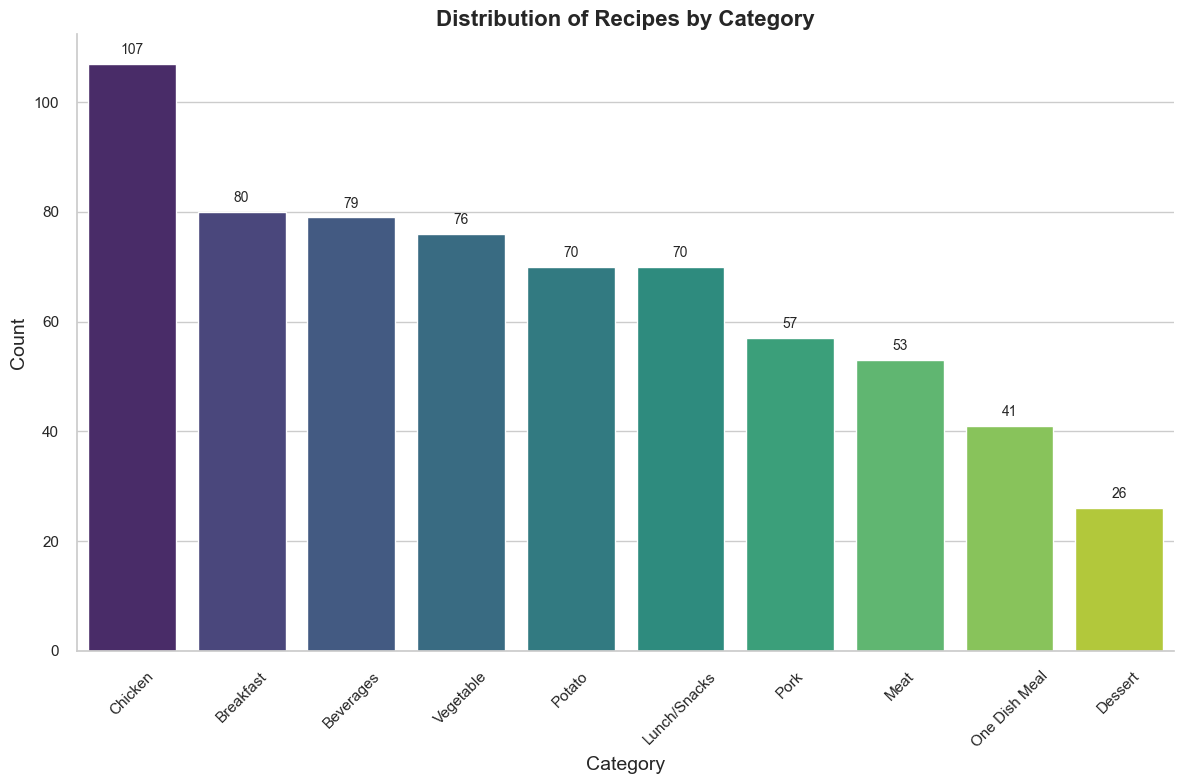

In [20]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Prepare the data: count the occurrences of each category
category_counts = data_without_outliers['category'].value_counts().reset_index()
category_counts.columns = ['category', 'count']

# Increase the size of the plot
plt.figure(figsize=(12, 8))

# Create the bar plot with a different colour palette
ax = sns.barplot(x='category', y='count', data=category_counts, palette='viridis')

# Customize the appearance
ax.set_title('Distribution of Recipes by Category', fontsize=16, fontweight='bold')
ax.set_xlabel('Category', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
plt.xticks(rotation=45)  # Rotate the category labels to improve readability

# Annotate each bar with the count
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points',
                fontsize=10)

# Remove the top and right spines
sns.despine()

# Show the plot
plt.tight_layout()
plt.show()

The distribution of data across the caetegory types between 71 and 106 demonstrates that there isnt a significaent class imbalance for this feature. Therefore, there may be enough data of each type to not have to include oversampling techniques

## Visualising the Target Variable 

The taget variable must be reviewed to determine whether there could be an issue an imbalanced dataset

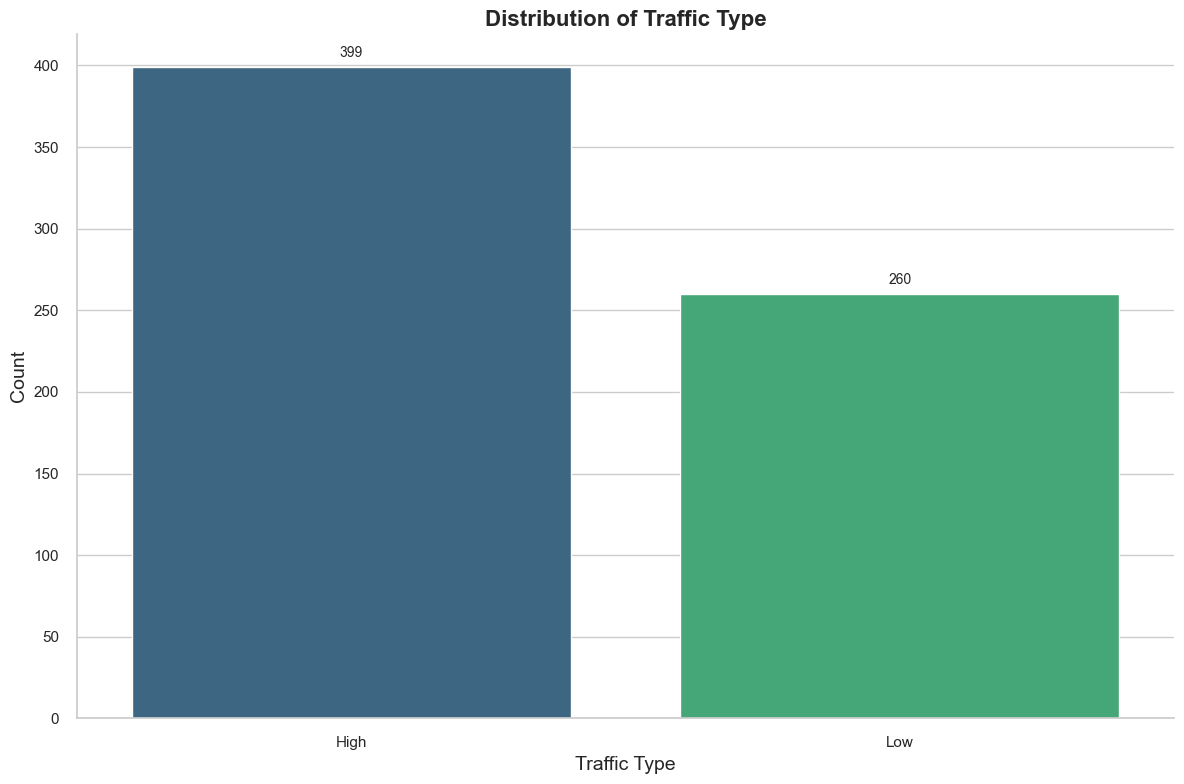

In [21]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Prepare the data: count the occurrences of each category
category_counts = data_without_outliers['high_traffic'].value_counts().reset_index()
category_counts.columns = ['high_traffic', 'count']

# Increase the size of the plot
plt.figure(figsize=(12, 8))

# Create the bar plot with a different colour palette
ax = sns.barplot(x='high_traffic', y='count', data=category_counts, palette='viridis')

# Customize the appearance
ax.set_title('Distribution of Traffic Type', fontsize=16, fontweight='bold')
ax.set_xlabel('Traffic Type', fontsize=14)
ax.set_ylabel('Count', fontsize=14)

# Annotate each bar with the count
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points',
                fontsize=10)

# Remove the top and right spines
sns.despine()

# Show the plot
plt.tight_layout()
plt.show()

There is a class imbalance here as there are around 200 more examples of high traffic then low traffic. This may be revisited once the models have been trained to assess whether oversampling techniques such as SMOTE or value duplication are required

## Cluster Aanlysis using PCA

In [22]:
scaler = StandardScaler()

target = data_without_outliers['high_traffic'].map({'High': 1, 'Low': 0})
features = pd.get_dummies(data_without_outliers.drop(['high_traffic', 'recipe'], axis=1))

pca = PCA(n_components=2)

pca_features = pca.fit_transform(scaler.fit_transform(features))

pca_df = pd.DataFrame(pca_features, columns = ['PCA_1', 'PCA_2'])
pca_df['traffic_score'] = target

<AxesSubplot: xlabel='PCA_1', ylabel='PCA_2'>

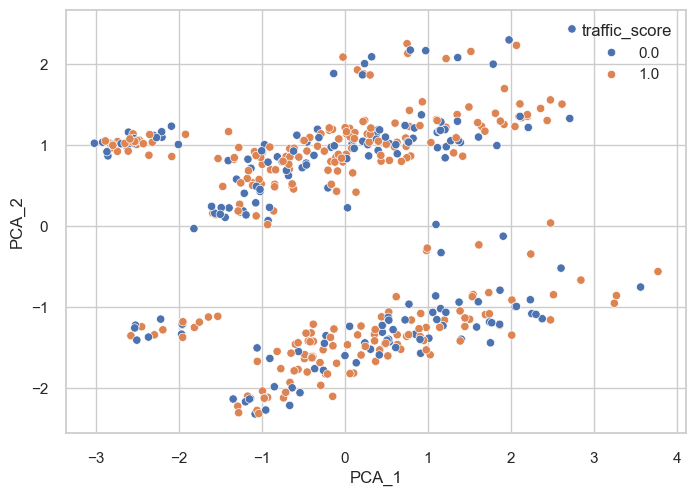

In [23]:
sns.scatterplot(data=pca_df, x='PCA_1', y = 'PCA_2', hue='traffic_score')

# Initial Model Training

![image](image.png)


![F1_Score](F1_Score.png)


## Prepare the data for machine learning

The steps involved in this process will be to 

1. Convert categorical data to numerical data
2. Split the data into test and train datasets
3. Perform feature scaling
4. Train and evaluate using Logisitc Regression (default parameters only)
5. Train and evaluate using RandomForrestClassifier (default parameters only)
6. Train and evaluate using XGBoostClassifier (default parameters only)
7. Choose a model for hyper parameter optimisation

### Convert Categorical Data to Numerical Data

I will use the pd.get_dummies method to convert the meal category in to a one hot encoded values and return into a new dataframe.
I will also convert the target variable into a one hot encoded dataframe

In [24]:
target = data_without_outliers['high_traffic'].map({'High': 1, 'Low': 0})
features = pd.get_dummies(data_without_outliers.drop(['high_traffic', 'recipe'], axis=1))

In [25]:
data_without_outliers.to_csv('cleaned_data.csv') # Save the cleaned data for review

### Split into test and train sets

In [26]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=123)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((461, 18), (198, 18), (461,), (198,))

### Perform feature scaling

In [27]:
scaler = MinMaxScaler()

Scaled_X_train = scaler.fit_transform(X_train)
Scaled_X_test = scaler.transform(X_test)

# Check the scaling has worked correctly
Scaled_X_train[0][:]

array([2.63329099e-04, 9.82075594e-01, 1.41673932e-01, 1.17339186e-01,
       0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

## Assess Three ML Techniques with Evaluation

### Perform Logistic Regression Analysis

In [28]:
log = LogisticRegression()

log.fit(Scaled_X_train, y_train)

y_pred = log.predict(Scaled_X_test)

score = classification_report(y_test, y_pred)
print(score)
print(f"Accuracy = {round(100 * accuracy_score(y_test, y_pred), 0)}%")

              precision    recall  f1-score   support

           0       0.77      0.67      0.71        69
           1       0.83      0.89      0.86       129

    accuracy                           0.81       198
   macro avg       0.80      0.78      0.79       198
weighted avg       0.81      0.81      0.81       198

Accuracy = 81.0%


The classification model demonstrates strong performance, with an overall accuracy of **81%**, effectively distinguishing between two classes. 

Class 1 outperforms class 0 across precision (83% vs. 77%), recall (89% vs. 67%), and F1-score (0.86 vs. 0.71), indicating a more reliable prediction for class 1 instances. Despite the imbalance between class 0 (69 instances) and class 1 (129 instances), the model maintains balanced metrics, as shown by the weighted averages, all at 0.81. 

The results highlight the model's capability in classification, particularly for class 1, while suggesting potential for improvement in class 0's recall. This analysis confirms the model as an effective tool for classification, albeit with room for refinement in certain areas.

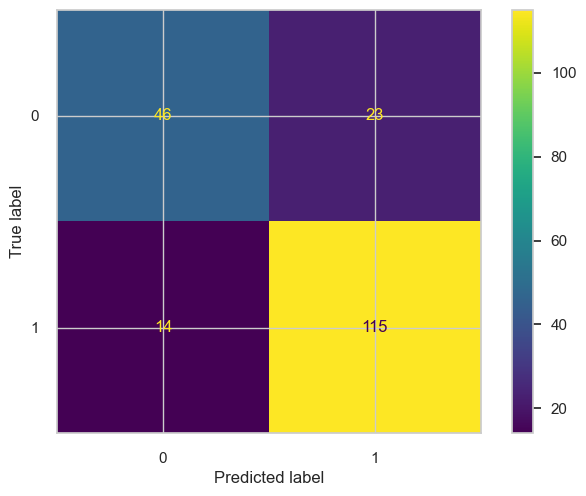

In [29]:
matrix = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
matrix.plot()

### Perform Random Forest Classifier

In [30]:

rfc = RandomForestClassifier()

rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

score = classification_report(y_test, y_pred)
print(score)
print(f"Accuracy = {round(100 * accuracy_score(y_test, y_pred), 0)}%")

              precision    recall  f1-score   support

           0       0.67      0.61      0.64        69
           1       0.80      0.84      0.82       129

    accuracy                           0.76       198
   macro avg       0.73      0.72      0.73       198
weighted avg       0.75      0.76      0.75       198

Accuracy = 76.0%


The classification model exhibits solid performance with an overall accuracy of **75%**, effectively differentiating between the two classes. 

Class 1 shows a higher level of performance than class 0, with a precision of 79% versus 67%, a recall of 84% versus 58%, and an F1-score of 0.82 versus 0.62. 

These results indicate that the model is more accurate and reliable in identifying class 1 instances. The support values reveal an imbalance in the dataset, with 69 instances for class 0 and 129 for class 1. 

Despite this, the weighted average metrics are all at 0.75, suggesting that the model handles the class imbalance well. The analysis confirms the model's effective classification capability, particularly for class 1, while also pointing out areas for potential improvement in predicting class 0 more accurately.

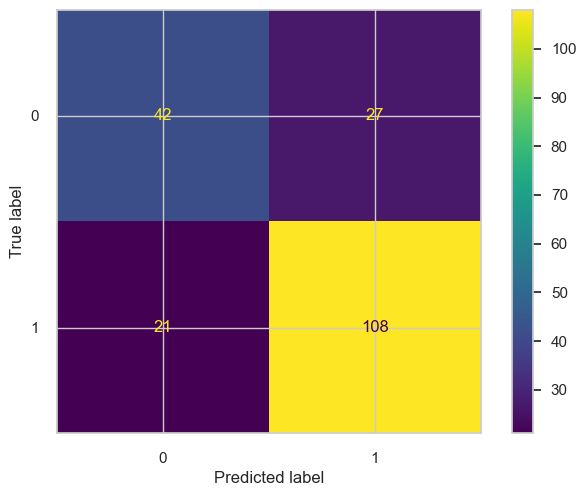

In [31]:
matrix = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
matrix.plot()

### XGBoost Classifier

In [32]:

xgb = xgb.XGBClassifier()

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

score = classification_report(y_test, y_pred)
print(score)
print(f"Accuracy = {round(100 * accuracy_score(y_test, y_pred), 0)}%")

              precision    recall  f1-score   support

           0       0.60      0.55      0.58        69
           1       0.77      0.81      0.79       129

    accuracy                           0.72       198
   macro avg       0.69      0.68      0.68       198
weighted avg       0.71      0.72      0.71       198

Accuracy = 72.0%


The classification model demonstrates satisfactory performance, achieving an overall accuracy of **72%** in distinguishing between two classes. 

Class 1 surpasses class 0 in terms of precision (77% vs. 60%), recall (81% vs. 55%), and F1-score (0.79 vs. 0.58), indicating that the model predicts class 1 instances with higher accuracy and reliability. With 69 instances for class 0 and 129 for class 1, the dataset shows class imbalance. 

However, the weighted average metrics, standing at 0.71, indicate that the model compensates for this imbalance effectively. This analysis suggests that while the model is capable of classifying instances with a reasonable degree of accuracy, especially for class 1, there is room for improvement in enhancing the predictive performance for class 0.

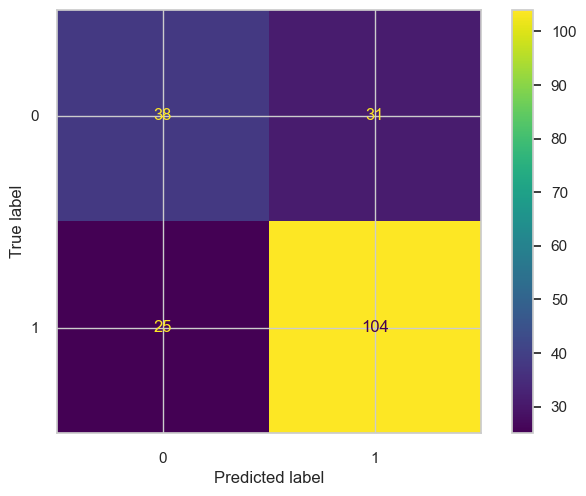

In [33]:
matrix = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
matrix.plot()

### Summary

Logistic Regression showed a balanced performance with an overall accuracy of 81%, indicating a strong ability to classify instances. It particularly excelled in predicting class 1 with high precision and recall. Despite the class imbalance, it achieved weighted averages of 0.81 across metrics, suggesting effective handling of class distribution and a high degree of reliability in classification tasks.

Random Forest displayed solid performance with a slight drop in overall accuracy to 75% compared to Logistic Regression. Class 1 again showed better results than class 0, but the gap between the performance metrics of the two classes was narrower. This model maintained a good balance between precision and recall, with weighted averages reflecting a consistent performance across the classes, despite a noticeable class imbalance.

XGBoost demonstrated satisfactory performance with the lowest overall accuracy among the three models at 72%. Like the other models, it was more effective in identifying class 1 instances but showed a need for improvement in class 0 predictions. The weighted average metrics indicated that while the model could manage class imbalance, its predictive accuracy and reliability were less optimal compared to the other two models.

In summary, all three models demonstrated competency in classifying the given instances, particularly favoring class 1. Logistic Regression emerged as the most effective, showing high accuracy and balanced performance across classes. Random Forest followed, with slightly lower accuracy but still robust in handling class imbalance. XGBoost, while still capable, lagged slightly behind in terms of overall effectiveness, indicating potential areas for improvement, especially in predicting class 0 more accurately. Each model's performance suggests different strengths and areas for enhancement, highlighting the importance of model selection and tuning based on the specific requirements and characteristics of the classification task at hand.

## Broadining Scope with PyCaret 

### Model Scanning with PyCaret

There has been mixed success performing the predictions using Logistic Regression, Random Forest and XGBoost. Logisitic Regression appears to be the best performing model and meets the requirements of the customer of 80%.

However, there are some issues with the classification of the class 0, therefore, additional models will be fit with the aim of improving the precision and recall of the 0 class (Low Traffic).

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,20:43:45
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,20:44:29
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,20:44:31
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


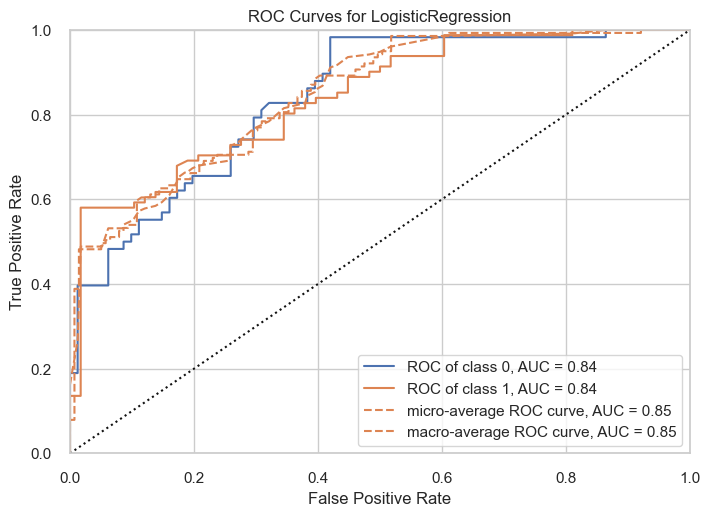

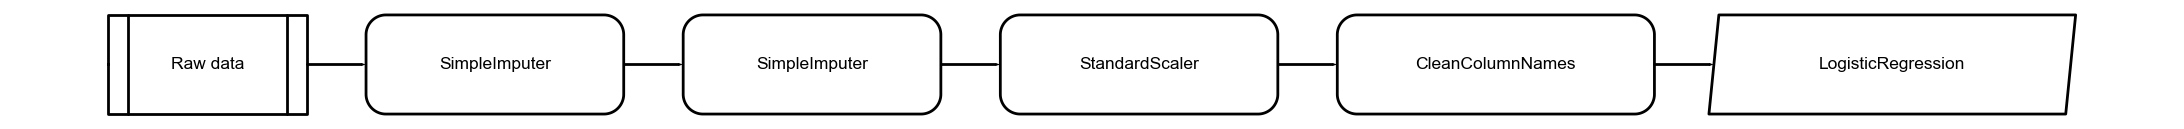

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [34]:

pycaret_df = pd.DataFrame(X_train)
pycaret_df['target'] = y_train

# Step 1: Setup the environment in PyCaret
clf1 = setup(data=pycaret_df, target='target', session_id=123,
             normalize=True, 
             log_experiment=True, 
             experiment_name='model_screen')  # Adjust based on your specific requirements

# Step 2: Compare models to find the best base model based on F1 score
best_model = compare_models(sort='F1')

# Step 3: Create a model - Example with Logistic Regression
lr = create_model('lr')

# Step 4: Tune the model to optimize F1 score
tuned_lr = tune_model(lr, optimize='F1')

# Step 5: Plot the model - Example: AUC Plot
plot_model(tuned_lr, plot='auc')

# Step 6: Evaluate the model - This opens up a dashboard for in-depth analysis
evaluate_model(tuned_lr)

In [35]:
tuned_lr

LogisticRegression(C=0.056, class_weight={}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [67]:
log = LogisticRegression(C=0.1, class_weight={}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) # Tweaked the C term to imporve balanced accuracy

std_scaler = StandardScaler()

sScaled_X_Train = std_scaler.fit_transform(X_train.drop('target', axis=1))
sScaled_X_Test = std_scaler.transform(X_test)

log.fit(sScaled_X_Train, y_train)

y_pred = log.predict(sScaled_X_Test)

score = classification_report(y_test, y_pred)
print(score)
print(f"Accuracy = {round(100 * accuracy_score(y_test, y_pred), 0)}%")

              precision    recall  f1-score   support

           0       0.74      0.70      0.72        69
           1       0.84      0.87      0.85       129

    accuracy                           0.81       198
   macro avg       0.79      0.78      0.79       198
weighted avg       0.81      0.81      0.81       198

Accuracy = 81.0%


The model showcases an overall accuracy of **81%**, with class 1 predictions (precision: 0.84, recall: 0.87) slightly outperforming class 0 (precision: 0.74, recall: 0.70). The F1-scores further reflect this trend, with class 1 achieving 0.85 and class 0 at 0.72. Both macro and weighted averages across precision, recall, and F1-score hover around 0.79 to 0.81, indicating a balanced and effective performance across the classes.

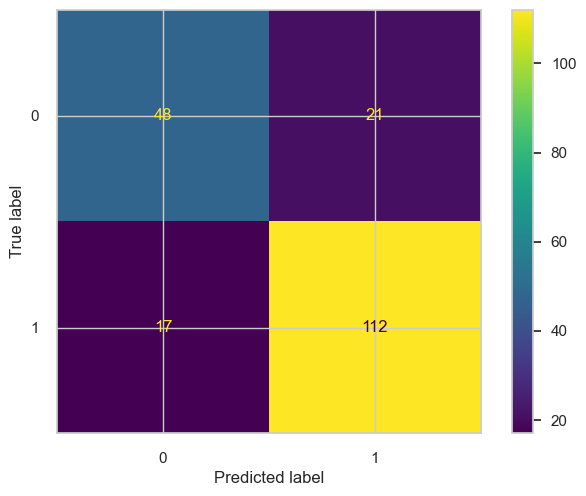

In [38]:
matrix = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
matrix.plot()

# Hyper Parameter Tuning

## Choose a model for hyper parameter optimisation

The models demonstrated similar performance for each ML algorithm with Logistic Regression performing best.

However, due to the power of XGBoost, this will be selected for hyper parameter fine-tuning due to its overall perfomance within the machine learning community. It has a wide range of hyperparameters that can be used for tuning and also comes with some handy tools to extract feature importance from the data.

## Initial Random Search for Optimisation

I will use the sklearn RandomizedSearchCV library to perform optimisation and cross validation on a broader range of hyperparameters before doing some fine tuning with a grid search.

To ensure that the random search is able to scan across a wider experimental space, the search will be performed 10 times in a for loop and output to a dataframe.

In [76]:

# Define the model
xgb = XGBClassifier()

# Parameter distribution
param_dist = {
    'n_estimators': np.arange(100, 1001, 100),
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': np.arange(3, 11, 1),
    'min_child_weight': np.arange(1, 6, 1),
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0, 0.01, 0.1],
    'max_delta_step': [0, 1, 2, 5, 10],
    'booster': ['gbtree'],
    'tree_method': ['auto', 'exact', 'approx', 'hist', 'gpu_hist'],
    'sampling_method': ['uniform', 'gradient_based'],
    'predictor': ['auto']
}

score = []
parameters = []

for i in range(0, 10):
    # Configure RandomizedSearchCV
    random_search = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=10, scoring='f1', n_jobs=-1, cv=5, verbose=0)

    # Fit the model
    random_search.fit(X_train.drop('target', axis=1), y_train)

    # Best parameters and score
    best_parameters = random_search.best_params_
    best_score = random_search.best_score_
    (print(f"--------------Test - {i+1}----------"))
    parameters.append(best_parameters)
    score.append(best_score)

random_search_df = pd.DataFrame(zip(score, parameters), columns=['best_score', 'best_params'])

random_search_df['best_score'].astype('float')
random_search_df.sort_values(by='best_score', inplace=True, ascending=False)
random_search_df.to_csv('initial_randomised_search.csv')
random_search_df.iloc[0,1]

--------------Test - 1----------
--------------Test - 2----------
--------------Test - 3----------
--------------Test - 4----------
--------------Test - 5----------
--------------Test - 6----------
--------------Test - 7----------
--------------Test - 8----------
--------------Test - 9----------
--------------Test - 10----------


{'tree_method': 'exact',
 'subsample': 1.0,
 'sampling_method': 'gradient_based',
 'reg_lambda': 0,
 'reg_alpha': 0,
 'predictor': 'auto',
 'n_estimators': 100,
 'min_child_weight': 4,
 'max_depth': 4,
 'max_delta_step': 2,
 'learning_rate': 0.01,
 'gamma': 0.1,
 'colsample_bytree': 0.7,
 'booster': 'gbtree'}

## Grid Search for Fine Tuning

In [77]:

# Assuming you have a dataset X (features) and y (target)

# Define the XGBoost classifier
xgb_clf = XGBClassifier()

# Define the parameter grid
param_grid = {
    'tree_method': ['exact'], 
    'subsample': [0.9, 1], 
    'sampling_method': ['gradient_based'], 
    'reg_lambda': [0],
    'reg_alpha': [0],
    'predictor': ['auto'],
    'n_estimators': [50, 100, 150],
    'min_child_weight': [3, 4],
    'max_depth': [4, 6],
    'max_delta_step': [2],
    'learning_rate': [0.011, 0.01, 0.009],
    'gamma': [0.1],
    'colsample_bytree': [0.8, 0.7],
    'booster': ['gbtree']
}

# Set up GridSearchCV
xgb_grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring='f1', cv=5, verbose=1, n_jobs=-1)

# Fit the grid search to the data
xgb_grid_search.fit(X_train.drop('target', axis=1), y_train)


Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max...
                         'gamma': [0.1], 'learning_rate': [0.011, 0.01, 0.009],
                         'max_delta_step': [2], 'max_depth': [4, 6],
                         'min_child_weight': [3, 4],
                         'n_estimators': [50, 100, 150], 'predictor': ['auto'],
                         'reg_alpha': [0], 'reg_lambda': [0],
                         'sampling_method': ['gradient_based'],
                         'subsample': [0.9, 1], 'tree_method': ['exact']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=1)

In [78]:
print("Best parameters found: ", xgb_grid_search.best_params_)
print("Best accuracy found: ", xgb_grid_search.best_score_)

Best parameters found:  {'booster': 'gbtree', 'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.011, 'max_delta_step': 2, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 100, 'predictor': 'auto', 'reg_alpha': 0, 'reg_lambda': 0, 'sampling_method': 'gradient_based', 'subsample': 1, 'tree_method': 'exact'}
Best accuracy found:  0.8014394283475846


In [79]:
best_params = xgb_grid_search.best_params_

# Initialize a new XGBoost classifier with the best parameters
xgb_clf_best = XGBClassifier(**best_params)

# Fit the model with the best parameters to the training data
xgb_clf_best.fit(X_train.drop('target', axis=1), y_train)

# Predict on the test set
predictions = xgb_clf_best.predict(X_test)

# evaluate the predictions
score = classification_report(y_test, predictions)
print(score)
print(f"Accuracy = {round(100 * accuracy_score(y_test, predictions), 0)}%")

              precision    recall  f1-score   support

           0       0.76      0.61      0.68        69
           1       0.81      0.90      0.85       129

    accuracy                           0.80       198
   macro avg       0.79      0.75      0.77       198
weighted avg       0.79      0.80      0.79       198

Accuracy = 80.0%


After tuning, the XGBoost model has demonstrated a marked improvement, achieving an overall accuracy of 80%. The fine-tuning process has particularly bolstered the model's performance in classifying both classes with increased precision and recall.

Class 0: The model's precision for class 0 has improved to 76%, and recall to 61%, with the F1-score climbing to 0.68. These enhanced metrics indicate the model has become more adept at correctly identifying class 0 instances, with fewer instances of misclassification.

Class 1: Precision for class 1 has maintained at 81% post-tuning, but recall has seen a slight increase to 90%, bringing the F1-score up to 0.85. This confirms the model's robustness in identifying class 1 instances, demonstrating high accuracy and a low rate of false negatives.

The macro average metrics, which consider the performance across both classes, reflect a balanced improvement with precision, recall, and F1-score averaging at 0.79, 0.75, and 0.77, respectively. The weighted average metrics, accounting for class imbalance, show precision and F1-score at 0.79 and accuracy at 0.80, indicating that the model's predictive power is well-calibrated to the proportion of each class within the dataset.

In summary, the XGBoost model's tuning has successfully enhanced its classification accuracy and achieved a more balanced performance between classes. The precision, recall, and F1-score improvements for both classes underscore the benefits of careful model tuning in achieving superior prediction accuracy and reliability. With these refinements, the XGBoost model has strengthened its position as a robust option for classification tasks, showcasing improved predictive capabilities.

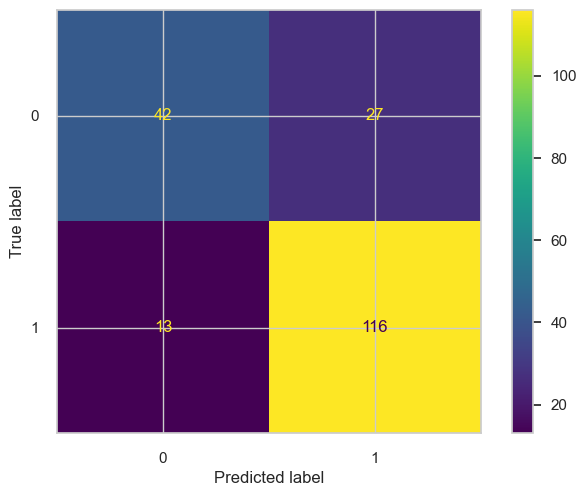

In [80]:
matrix = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions))
matrix.plot()

## Assessing Feature Importance

Text(0.5, 1.0, 'Breakdown of Feature Importance')

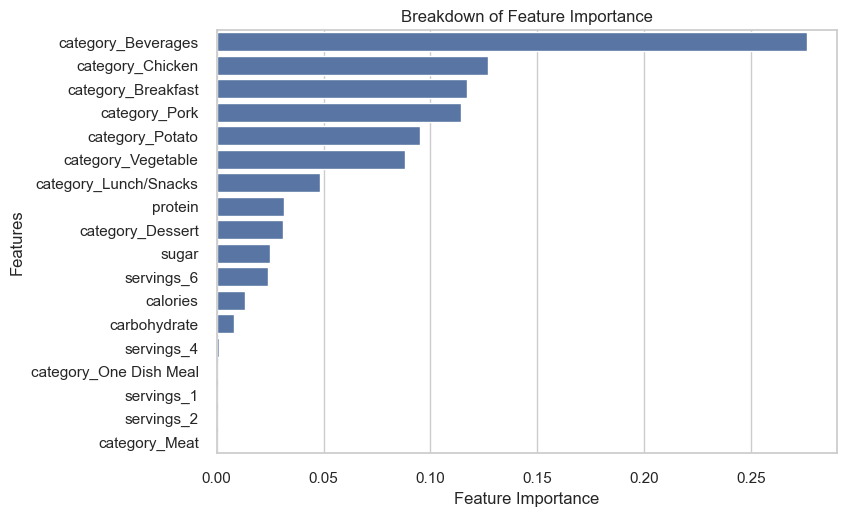

In [81]:
# Get feature importance
feature_importance = xgb_clf_best.feature_importances_
# Get feature names
feature_names = features.columns.tolist()

feature_df = pd.DataFrame(zip(feature_importance, feature_names), columns=['importances', 'feature_names']).sort_values('importances', ascending=False)
# Create a bar chart
sns.barplot(data=feature_df, x='importances', y='feature_names')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Breakdown of Feature Importance')

The features of greatest importance are;

1. Beverages
2. Chicken
3. Breakfast
4. Pork
5. Potato

Lets review the number of high and low traffic scores for these categories

In [93]:
top5_cats = feature_df.iloc[:5,1].str.replace('category_', '').to_list()

for item in top5_cats:
    # Obtain the counts of 'high_traffic' for each category
    target_counts = data_without_outliers[data_without_outliers['category'] == item]['high_traffic'].value_counts()
    
    # Set the name of the Series which will be used as the column name when converting to a DataFrame for pretty printing
    target_counts.name = 'Traffic Score'
    
    # Now convert the Series to a DataFrame and print it
    print(f"---------- {item} ------------\n")
    print(target_counts.reset_index().rename(columns={'index': ''}))
    print()
    print(f"------------------------------\n")


---------- Beverages ------------

         Traffic Score
0   Low             75
1  High              4

------------------------------

---------- Chicken ------------

         Traffic Score
0   Low             62
1  High             45

------------------------------

---------- Breakfast ------------

         Traffic Score
0   Low             54
1  High             26

------------------------------

---------- Pork ------------

         Traffic Score
0  High             53
1   Low              4

------------------------------

---------- Potato ------------

         Traffic Score
0  High             67
1   Low              3

------------------------------



## Model Optimisation with Important Features

I will assess the model performance when removing features that do not appear to have an effect on the model performance.

In [95]:
top13_features = feature_df.iloc[:13,:]
top13_features = top13_features['feature_names'].to_list()
trimmed_features = features[top13_features]

X_train, X_test, y_train, y_test = train_test_split(trimmed_features, target, test_size=0.3, random_state=123)

Scaled_X_train = scaler.fit_transform(X_train)
Scaled_X_test = scaler.transform(X_test)

### Randomised Search

In [99]:
# Define the model
model = XGBClassifier()

# Parameter distribution
param_dist = {
    'n_estimators': np.arange(100, 1001, 100),
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': np.arange(3, 11, 1),
    'min_child_weight': np.arange(1, 6, 1),
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0],
    'reg_lambda': [0],
    'max_delta_step': [0, 1, 2, 5, 10],
    'booster': ['gbtree'],
    'tree_method': ['auto', 'exact', 'approx', 'hist', 'gpu_hist'],
    'sampling_method': ['uniform', 'gradient_based'],
    'predictor': ['auto']
}

score = []
parameters = []

for i in range(0, 10):
    # Configure RandomizedSearchCV
    random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, scoring='f1', n_jobs=-1, cv=5, verbose=0)

    # Fit the model
    random_search.fit(X_train, y_train)

    # Best parameters and score
    best_parameters = random_search.best_params_
    best_score = random_search.best_score_
    (print(f"--------------Test - {i+1}----------"))
    parameters.append(best_parameters)
    score.append(best_score)

grid_search_df = pd.DataFrame(zip(score, parameters), columns=['best_score', 'best_params'])

grid_search_df.sort_values(by='best_score', inplace=True, ascending=False)
grid_search_df.iloc[0,1]

--------------Test - 1----------
--------------Test - 2----------
--------------Test - 3----------
--------------Test - 4----------
--------------Test - 5----------
--------------Test - 6----------
--------------Test - 7----------
--------------Test - 8----------
--------------Test - 9----------
--------------Test - 10----------


{'tree_method': 'exact',
 'subsample': 0.8,
 'sampling_method': 'uniform',
 'reg_lambda': 0,
 'reg_alpha': 0,
 'predictor': 'auto',
 'n_estimators': 100,
 'min_child_weight': 4,
 'max_depth': 3,
 'max_delta_step': 5,
 'learning_rate': 0.01,
 'gamma': 0.2,
 'colsample_bytree': 0.9,
 'booster': 'gbtree'}

### Grid Search Following Randomised search

In [102]:
# Define the XGBoost classifier
xgb_clf = XGBClassifier()

# Define the parameter grid
param_grid = {
    'tree_method': ['exact'], 
    'subsample': [0.9, 0.8], 
    'sampling_method': ['uniform'], 
    'reg_lambda': [0],
    'reg_alpha': [0],
    'predictor': ['auto'],
    'n_estimators': [50, 100, 150],
    'min_child_weight': [6, 3, 4],
    'max_depth': [3, 4],
    'max_delta_step': [5],
    'learning_rate': [0.011, 0.01, 0.009],
    'gamma': [0.2],
    'colsample_bytree': [0.8, 0.9],
    'booster': ['gbtree']
}


# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring='f1', cv=5, verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max...
                         'gamma': [0.2], 'learning_rate': [0.011, 0.01, 0.009],
                         'max_delta_step': [5], 'max_depth': [3, 4],
                         'min_child_weight': [6, 3, 4],
                         'n_estimators': [50, 100, 150], 'predictor': ['auto'],
                         'reg_alpha': [0], 'reg_lambda': [0],
                         'sampling_method': ['uniform'],
                         'subsample': [0.9, 0.8], 'tree_method': ['exact']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=1)

### Testing the New Data and Model

In [104]:
best_params = grid_search.best_params_

# Initialize a new XGBoost classifier with the best parameters
xgb_clf_best = XGBClassifier(**best_params)

# Fit the model with the best parameters to the training data
xgb_clf_best.fit(X_train, y_train)

# Predict on the test set
predictions = xgb_clf_best.predict(X_test)

# evaluate the predictions
score = classification_report(y_test, predictions)
print(score)
print(f"Accuracy = {round(100 * accuracy_score(y_test, predictions), 0)}%")

              precision    recall  f1-score   support

           0       0.75      0.65      0.70        69
           1       0.83      0.88      0.85       129

    accuracy                           0.80       198
   macro avg       0.79      0.77      0.78       198
weighted avg       0.80      0.80      0.80       198

Accuracy = 80.0%


The model exhibits a good performance in classifying two classes, with an overall accuracy of **80%**. 

It is more effective in predicting class 1 (precision 83%, recall 88%, F1-score 0.85) than class 0 (precision 75%, recall 65%, F1-score 0.70). The metrics suggest the model has a higher reliability in identifying class 1 instances, while class 0 predictions could benefit from improved recall. 

The balanced macro average scores indicate a relatively fair performance across both classes, with the weighted scores affirming the model's efficacy considering class distribution.

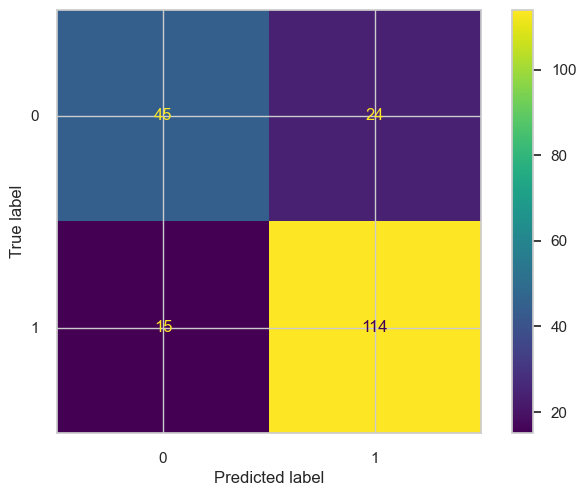

In [105]:
matrix = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions))
matrix.plot()

### Refitting the Logistic Regression Model

In [110]:
log = LogisticRegression(C=1.1, class_weight={}, dual=False, fit_intercept=True,
                   intercept_scaling=0.9, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

log.fit(Scaled_X_train, y_train)

y_pred = log.predict(Scaled_X_test)

score = classification_report(y_test, y_pred)
print(score)
print(f"Accuracy = {round(100 * accuracy_score(y_test, y_pred), 0)}%")

              precision    recall  f1-score   support

           0       0.73      0.71      0.72        69
           1       0.85      0.86      0.85       129

    accuracy                           0.81       198
   macro avg       0.79      0.79      0.79       198
weighted avg       0.81      0.81      0.81       198

Accuracy = 81.0%


The logistic regression model achieves an overall accuracy of **81%**, showing a balanced classification with precision and recall almost equal for both classes. 

Class 0 has a precision of 0.73 and a recall of 0.71, while class 1 exhibits slightly higher precision and recall at 0.85 and 0.86, respectively. 

The macro average of 0.79 for precision, recall, and F1-score indicates a harmonious balance in performance across classes, and the weighted averages are consistent with the model's accuracy, considering class distribution.

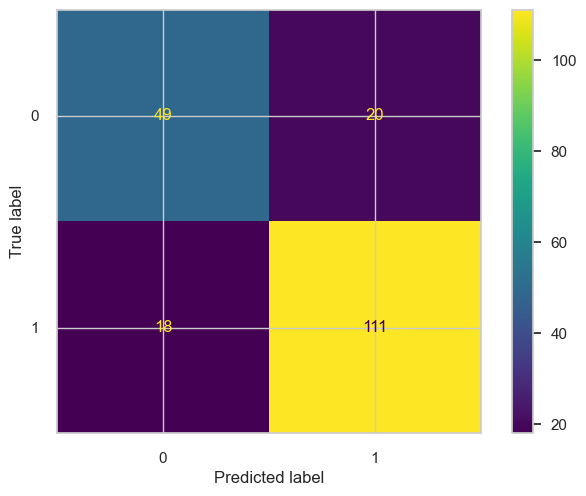

In [111]:
matrix = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
matrix.plot()

# Improving Class Imbalance

The overall perfomance on the classification has been affected by the ability to predict the 0 class (Low).

In an attempt to improve this, an oversampling technique will be used to randomly generate values of the 0 class (Low)

## SMOTE oversampling

Preparing the dataset using the SMOTE oversampling method that is within the imblearn package.

In [123]:

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=123)

# Initialize SMOTE
smote = SMOTE(random_state=123)

# Applying SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Checking the class distribution after SMOTE
balanced_class_distribution = pd.Series(y_train_smote).value_counts()

balanced_class_distribution

0    270
1    270
Name: high_traffic, dtype: int64

## Randomised Search

In [125]:
# Define the model
model = XGBClassifier()

# Parameter distribution
param_dist = {
    'n_estimators': np.arange(100, 1001, 100),
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': np.arange(3, 11, 1),
    'min_child_weight': np.arange(1, 6, 1),
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0],
    'reg_lambda': [0],
    'max_delta_step': [0, 1, 2, 5, 10],
    'booster': ['gbtree'],
    'tree_method': ['auto', 'exact', 'approx', 'hist', 'gpu_hist'],
    'sampling_method': ['uniform', 'gradient_based'],
    'predictor': ['auto']
}


score = []
parameters = []

for i in range(0, 10):
    # Configure RandomizedSearchCV
    random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, scoring='f1', n_jobs=-1, cv=5, verbose=0)

    # Fit the model
    random_search.fit(X_train_smote, y_train_smote)

    # Best parameters and score
    best_parameters = random_search.best_params_
    best_score = random_search.best_score_
    (print(f"--------------Test - {i+1}----------"))
    parameters.append(best_parameters)
    score.append(best_score)

grid_search_df = pd.DataFrame(zip(score, parameters), columns=['best_score', 'best_params'])

grid_search_df.sort_values(by='best_score', ascending=False, inplace=True)
grid_search_df.to_csv('post_smote_randomsearch.csv')
grid_search_df.iloc[0,1]

--------------Test - 1----------
--------------Test - 2----------
--------------Test - 3----------
--------------Test - 4----------
--------------Test - 5----------
--------------Test - 6----------
--------------Test - 7----------
--------------Test - 8----------
--------------Test - 9----------
--------------Test - 10----------


{'tree_method': 'exact',
 'subsample': 1.0,
 'sampling_method': 'uniform',
 'reg_lambda': 0,
 'reg_alpha': 0,
 'predictor': 'auto',
 'n_estimators': 100,
 'min_child_weight': 2,
 'max_depth': 9,
 'max_delta_step': 0,
 'learning_rate': 0.3,
 'gamma': 0.2,
 'colsample_bytree': 0.9,
 'booster': 'gbtree'}

## Grid Search and Evaluation

In [126]:
# Define the XGBoost classifier
xgb_clf = XGBClassifier()

# Define the parameter grid
param_grid = {
    'tree_method': ['exact'], 
    'subsample': [0.9, 1.0], 
    'sampling_method': ['uniform'], 
    'reg_lambda': [0],
    'reg_alpha': [0],
    'predictor': ['auto'],
    'n_estimators': [50, 100, 150],
    'min_child_weight': [3, 2],
    'max_depth': [9, 8],
    'max_delta_step': [0],
    'learning_rate': [0.01, 0.011, 0.3],
    'gamma': [0.1, 0.2],
    'colsample_bytree': [0.9, 1.0],
    'booster': ['gbtree']
}


# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring='f1', cv=5, verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max...
                         'gamma': [0.1, 0.2],
                         'learning_rate': [0.01, 0.011, 0.3],
                         'max_delta_step': [0], 'max_depth': [9, 8],
                         'min_child_weight': [3, 2],
                         'n_estimators': [50, 100, 150], 'predictor': ['auto'],
                         'reg_alpha': [0], 'reg_lambda': [0],
                         'sampling_method': ['uniform'],
                         'subsample': [0.9, 1.0], 'tree_method': ['exact']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=1)

In [127]:
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)

Best parameters found:  {'booster': 'gbtree', 'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 50, 'predictor': 'auto', 'reg_alpha': 0, 'reg_lambda': 0, 'sampling_method': 'uniform', 'subsample': 1.0, 'tree_method': 'exact'}
Best accuracy found:  0.7886472422321723


## Fitting an XGBoost model on the Smote Data

In [128]:
best_params = grid_search.best_params_
# Initialize a new XGBoost classifier with the best parameters
xgb_clf_best = XGBClassifier(**best_params)

# Fit the model with the best parameters to the training data
xgb_clf_best.fit(X_train_smote, y_train_smote)

# Predict on the test set
predictions = xgb_clf_best.predict(X_test)

# evaluate the predictions
score = classification_report(y_test, predictions)
print(f"Parameter Index: {i}")
print(score)
print(f"Accuracy = {round(100 * accuracy_score(y_test, predictions), 0)}%")

Parameter Index: 9
              precision    recall  f1-score   support

           0       0.62      0.57      0.59        69
           1       0.78      0.81      0.80       129

    accuracy                           0.73       198
   macro avg       0.70      0.69      0.69       198
weighted avg       0.72      0.73      0.72       198

Accuracy = 73.0%


The XGBoost model, applied to SMOTE oversampled data, exhibits an accuracy of 73%. 

The model has a precision of 0.62 and recall of 0.57 for class 0, with a slightly higher precision of 0.78 and recall of 0.81 for class 1. The resulting F1-scores are 0.59 for class 0 and 0.80 for class 1, indicating a better performance for class 1. 

Overall, the model's macro average is 0.70 across precision, recall, and F1-score, showing relatively balanced performance, while the weighted average is 0.72, aligning closely with the accuracy and taking into account the class imbalance corrected by SMOTE.

However, oversampling by SMOTE and analysis with XGBoost has not yielded an expected increase in accuracy for class 0 or class 1

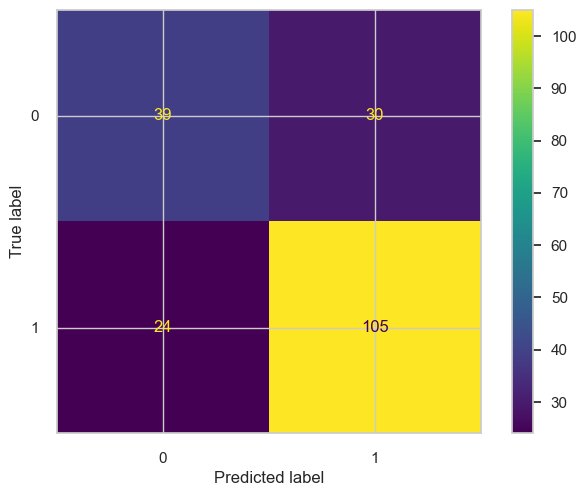

In [129]:
matrix = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions))
matrix.plot()

## Final Model Search with PyCaret

To cover all bases, I will try using PyCaret to see if there are any other models that will perform well on the SMOTE data

In [130]:

target = data_without_outliers['high_traffic'].map({'High': 1, 'Low': 0})
features = pd.get_dummies(data_without_outliers.drop(['high_traffic', 'recipe'], axis=1))
feature_smote, target_smote  = smote.fit_resample(features, target)
feature_smote['target'] = target_smote

# Setting up the environment in PyCaret
# The setup function initializes the environment and creates the transformation pipeline.
# It also performs data preprocessing tasks such as missing value imputation, categorical encoding, etc.
clf1 = setup(feature_smote, target = 'target', session_id=123, preprocess=True, index=False)

# Comparing all models to evaluate performance
# This function trains all the models in the model library using cross-validation and evaluates performance metrics.
best_models = compare_models(sort='f1', n_select=10, fold=5) 

print(best_models[0])

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,19:33:55
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/78 [00:00<?, ?it/s]

LinearDiscriminantAnalysis(covariance_estimator=None, n_components=None,
                           priors=None, shrinkage=None, solver='svd',
                           store_covariance=False, tol=0.0001)


In [131]:
best_models[0]

LinearDiscriminantAnalysis(covariance_estimator=None, n_components=None,
                           priors=None, shrinkage=None, solver='svd',
                           store_covariance=False, tol=0.0001)

## Fit and Evaluate the Best Model

### Fitting the Best Model - Linear Discriminant Analysis

In [134]:
best_model = best_models[0]

Scaled_X_train_smote = std_scaler.fit_transform(X_train_smote)
Scaled_X_test = std_scaler.transform(X_test)

best_model.fit(Scaled_X_train_smote, y_train_smote)

# Predict on the test set
predictions = best_model.predict(Scaled_X_test)

# evaluate the predictions
score = classification_report(y_test, predictions)
print(score)
print(f"Accuracy = {round(100 * accuracy_score(y_test, predictions), 0)}%")

              precision    recall  f1-score   support

           0       0.73      0.74      0.73        69
           1       0.86      0.85      0.86       129

    accuracy                           0.81       198
   macro avg       0.79      0.80      0.79       198
weighted avg       0.81      0.81      0.81       198

Accuracy = 81.0%


The LDA model displays an overall accuracy of **81%**, with a balanced classification efficacy for both classes. It achieves a precision of 0.73 and recall of 0.74 for class 0, alongside a higher precision of 0.86 and recall of 0.85 for class 1. The F1-scores are 0.73 for class 0 and 0.86 for class 1, reflecting strong performance, especially for class 1. Macro averages are 0.79, indicating uniformity across both classes, and weighted averages match the accuracy at 0.81, suggesting the model handles the class distribution well.

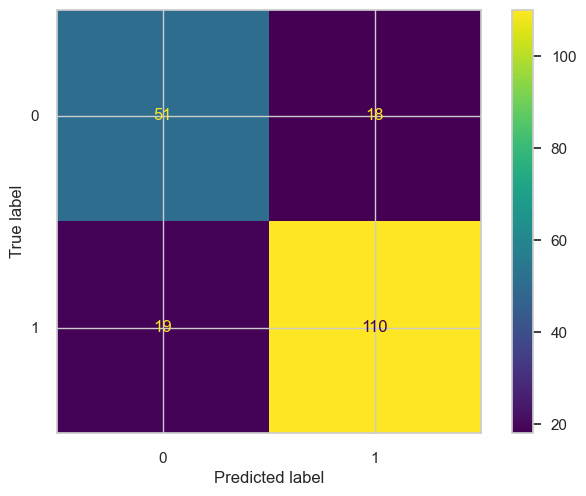

In [135]:
matrix = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions))
matrix.plot()

# Conclusion

The analysis of the provided data has yielded suitable results for predicting the level of traffic to the website. The key predictor class 1 (High Traffic) for this analysis was consistently higher in terms of precision and recall, which may be a symptom of class imbalance.

Prior to analysis, the data needed to be cleaned. Imputation of missing vlaues was required, with an approach taken to impute missing values depending on the food category. All categories were present and therefore the macronutrients could be filled with the median of data with the same category, i.e. the median of all the beverages category was filled into the rows with missing values and is a beverage.

The data was also very spread, with the data skewed to the left and a long tail, which was also shown with box plots. In order to remove potential outliers, the z-scores were used to remove the atypically high data for calories, carbohydrates, sugars and protein.

The initial training highlighted that Logistic Regression was the best model for predictions, even without hyper parameter tuning, with an accuracy of 81%. Folowing fine tuning with PyCaret, the Logistic Regression accuracy reduced to 80%. Models such as Random Forest and XGBoost showed lower accuracy, however, due to its popularity, the XGBoost algorithm was used for hyper parameter tuning to see if the class 0 accuracy could be improved.

The tuned XGBoost model improved significantly from the initial training, rising from 72% to 80%. However, the class 0 prediction still showed reduced accuracy. The feature importances from the XGBoost model were extracted, with the top 5 being.

Beverages - Low Traffic
Chicken - High Traffic
Breakfast - High Traffic
Pork - High Traffic
Potato - High Traffic

The top features were then extracted for retraining but this did not improve the accuracy for the XGBoost model but the Logistic Regression model maintained its high performance.

Due to the class imbalance and its potential effect on the overall performance, SMOTE oversampling has been applied to improve accuracy. This did not improve the accuracy of the XGBoost model with a reduction of accuracy to 72%. However, the PyCaret library was used to assess other models and Linear Discriminant Analysis yielded good results with an overall accuracy of 81%

The best results obtained throughout are as follows

**Initial Logistic Regression**

              precision    recall  f1-score   support

           0       0.77      0.67      0.71        69
           1       0.83      0.89      0.86       129

    accuracy                           0.81       198


**Fine Tuned Logistic Regression**

              precision    recall  f1-score   support

           0       0.74      0.70      0.72        69
           1       0.84      0.87      0.85       129

    accuracy                           0.81       198
    

**Logistic Regression with Top Features**

              precision    recall  f1-score   support

           0       0.73      0.71      0.72        69
           1       0.85      0.86      0.85       129

    accuracy                           0.81       198
   
   
**Linear Discriminant Analysis on SMOTE Data**

              precision    recall  f1-score   support

           0       0.73      0.74      0.73        69
           1       0.86      0.85      0.86       129

    accuracy                           0.81       198
    
All of these models have similar performance with an accuracy of 81% overall. However, there are various changes in the precision and recall between the models.

For simplicity, my recommendation would to be use the fined tuned Logistic Regression model. The model with trimmed features including the top 13 features from the XGBoost model did perform well, however, this did remove some category types, which is unlikely to be accepted by the customer.

Although the LDA with the oversampled data did possibly perform the best overall, there wasnt a significant increase and the effect of oversampling could introduce errors when applying to new data.

# Appendix

This is the model end to end

In [71]:
from joblib import dump, load # modules for saving the model

df = pd.read_csv('recipe_site_traffic_2212.csv')
df['high_traffic'] = df['high_traffic'].fillna('Low')
df['category'] =  df['category'].str.replace(' Breast', '')

df_grouped = df.groupby('category').agg(np.median)
df_grouped.reset_index(inplace=True)

# Create a dictionary for each nutrient mean by category for easier lookup
mean_values_dict = df_grouped.set_index('category')[['calories', 'carbohydrate', 'sugar', 'protein']].to_dict('index')

# Function to fill NaN values with the category mean
def fill_with_category_mean(row, nutrient):
    if pd.isnull(row[nutrient]):
        return mean_values_dict[row['category']][nutrient]
    else:
        return row[nutrient]

# Fill NaN values for each nutrient based on its category mean
for nutrient in ['calories', 'carbohydrate', 'sugar', 'protein']:
    df[nutrient] = df.apply(fill_with_category_mean, nutrient=nutrient, axis=1)

# Fill null values with the median for specified columns
columns_to_fill = ['carbohydrate', 'sugar', 'protein']

# Calculate Z-scores for the specified columns
z_scores = df[columns_to_fill].apply(zscore)

# Define outliers as rows where the absolute Z-score is greater than 2.25 in any of the specified columns
outliers = (z_scores.abs() > 1).any(axis=1)

# Data without outliers
data_without_outliers = df[~outliers]

# Fill null values with the median for specified columns
columns_to_fill = ['calories']

# Calculate Z-scores for the specified columns
z_scores = df[columns_to_fill].apply(zscore)

# Define outliers as rows where the absolute Z-score is greater than 2.25 in any of the specified columns
outliers = (z_scores.abs() > 2).any(axis=1)

# Data without outliers
data_without_outliers = data_without_outliers[~outliers]

target = data_without_outliers['high_traffic'].map({'High': 1, 'Low': 0})
features = pd.get_dummies(data_without_outliers.drop(['high_traffic', 'recipe'], axis=1))

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=123)

final_model = LogisticRegression(C=0.1, class_weight={}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) # Tweaked the C term to imporve balanced accuracy

std_scaler = StandardScaler()

sScaled_X_Train = std_scaler.fit_transform(X_train)
sScaled_X_Test = std_scaler.transform(X_test)

final_model.fit(sScaled_X_Train, y_train)

y_pred = final_model.predict(sScaled_X_Test)

score = classification_report(y_test, y_pred)
print(score)
print(f"Accuracy = {round(100 * accuracy_score(y_test, y_pred), 0)}%")

# Save your model to a file
dump(final_model, 'logistic_model.joblib')

"""

At a later point, you can load the model back into memory
`loaded_model = load('logistic_model.joblib')`

Use the loaded model to make predictions or continue training
`predictions = loaded_model.predict(YOUR_RECIPE_GOES_HERE)`

"""

              precision    recall  f1-score   support

           0       0.74      0.71      0.73        69
           1       0.85      0.87      0.86       129

    accuracy                           0.81       198
   macro avg       0.80      0.79      0.79       198
weighted avg       0.81      0.81      0.81       198

Accuracy = 81.0%


"\n\nAt a later point, you can load the model back into memory\n`loaded_model = load('logistic_model.joblib')`\n\nUse the loaded model to make predictions or continue training\n`predictions = loaded_model.predict(YOUR_RECIPE_GOES_HERE)`\n\n"